Load the data

In [11]:
sfCrime<-read.csv('sanfrancisco_incidents_summer_2014.csv')

Load the necessary packages

In [12]:
library(sp)
library(spacetime)
library(RColorBrewer)
library(OpenStreetMap)
library(lubridate)
library(scales)

First, we will see if there are any differences in total numbers of crimes on different days of the week

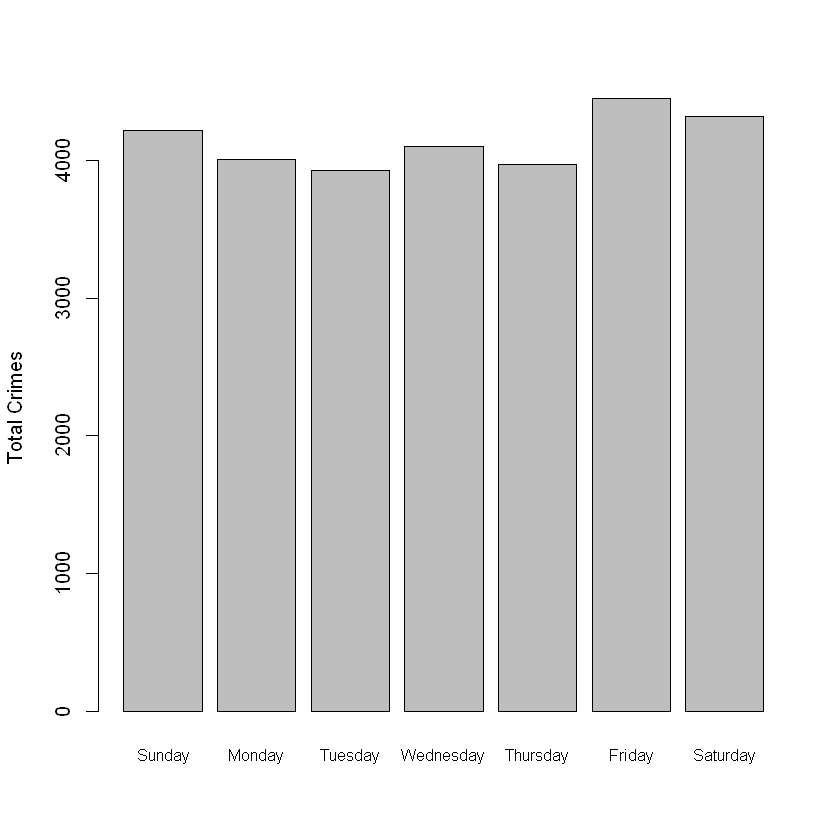

In [13]:
dayDict<-data.frame(day=c("Sunday", "Monday", "Tuesday",
           "Wednesday","Thursday",
           "Friday", "Saturday"), num=seq(1:7))

sfCrime$dayNum<-dayDict[match(sfCrime$DayOfWeek, dayDict$day),2]
table<-table(sfCrime$dayNum)
barplot(table, names.arg=dayDict$day, ylab="Total Crimes", cex.names=0.8)

Friday seems to have the most crimes followed by Saturday and Sunday but the differences are not very significant.

Next we will see if there is any diurnal pattern in crime rates and if this pattern varies by the day of the week. First we must prepare the data by adding a column for the hour of the day during which the crime occured.

In [14]:
time=strptime(as.character(sfCrime$Time),format='%H:%M')
sfCrime$crimeHour=hour(time)

Next we can tabulate the data by hour and day of the week

In [15]:
t = xtabs(~ dayNum + crimeHour, sfCrime)
dft<-data.frame(t)

Finally we can plot the data

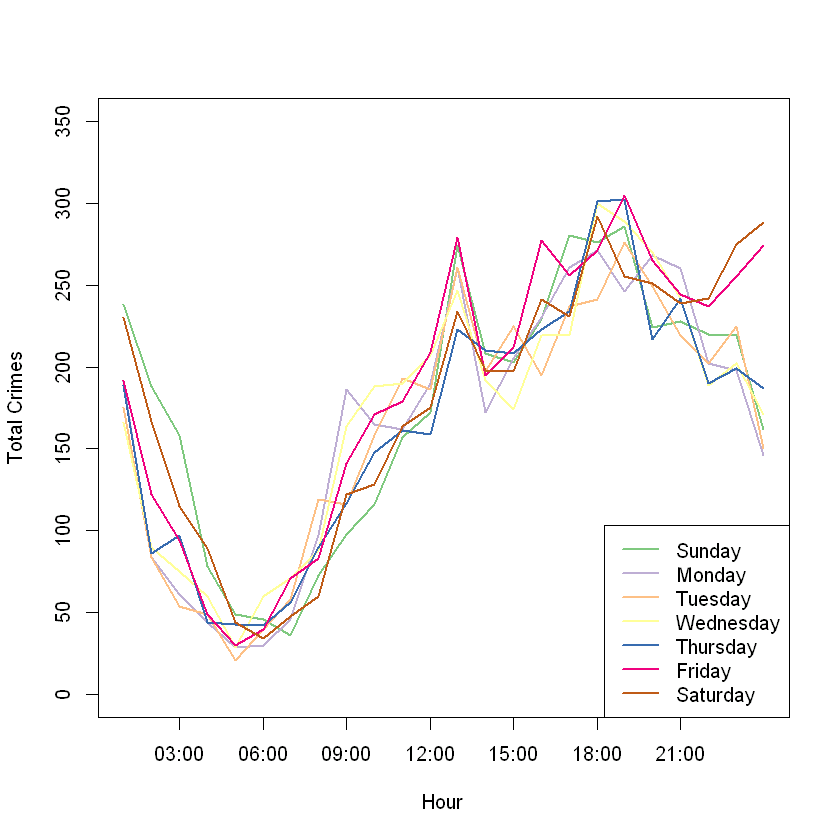

In [16]:
pal<-brewer.pal(7,  'Accent')


ts1<-ts(dft$Freq[dft$dayNum==1])
plot(ts1, xlab='Hour', ylab='Total Crimes', col=pal[1], lwd=2,
     ylim=c(0,350), xaxt='n')
for(i in 2:7)
{
  ts<-ts(dft$Freq[dft$dayNum==i])
  lines(ts, col=pal[i], lwd=2)
}
axis(side = 1, at = c(0,3,6,9,12,15,18,21), 
     labels = c('00:00', '03:00', '06:00' ,'09:00', '12:00', '15:00','18:00','21:00'))
legend('bottomright', legend=dayDict$day, 
       col=pal, lty=1, lwd=2)

A clear diurnal pattern has been presented. The most crime-free part of the part is around 5am. The crime rate then steadily increases until it peaks at about 6pm. There is also a local peak at about 1pm.

From Sunday to Thursday, the crime rate steadily decreases after  the 6pm peak until it reaches the low point of 5am the following morning. However, on Friday and Saturday evenings, the crime rate increases between 8pm and midnight, the period when the most people tend to be out celebrating the weekend, leaving their homes and cars unattended and generally making bad decisions.

Next we will look for trends in specific types of crimes by time of day and location. For clarity, we will restrict the analysis to only the eight most common categories of crimes.

First we must prepare the data and create the map using OpenStreetMaps.

In [17]:
coordinates(sfCrime) = ~X+Y #create Spatial Points Data Frame
proj4string(sfCrime) = "+proj=longlat +datum=WGS84"
sfCrimeOSM <- spTransform(sfCrime,osm()) 
# Convert to OpenStreetMap projection

lat <- c(37.83,37.7)
lon <- c(-122.52 ,-122.35) # San Fran coordinates

sfMap<- openmap(c(lat[1],lon[1]), c(lat[2],lon[2]), 
                       type='mapquest-aerial')

Nect we prepare the crime data for the eight most common crime categories in three hour windows

In [18]:
top8=names(sort(table(sfCrimeOSM$Category),decreasing=TRUE)[1:8])
#Ten most common crime categories
include=sfCrimeOSM$Category %in% top8
sfCrimeOSMtop8=sfCrimeOSM[include, ]
# get hour of day in 3 hour windows
library(lubridate)
time=strptime(as.character(sfCrimeOSMtop8$Time),format='%H:%M')
sfCrimeOSMtop8$hour=hour(time)%/%3
# name the time intervals for use in the plot
timePeriods=c('00:00 to 02:59', '03:00 to 05:59', '06:00 to 08:59',
              '09:00 to 11:59', '12:00 to 14:59', '15:00 to 17:59',
              '18:00 to 20:59', '21:00 to 23:59')

In [19]:
#Create a color code with good contrast
jColors <- data.frame(cat = top8, color = brewer.pal(8, 'Set3'))
sfCrimeOSMtop8$color=jColors[match(sfCrimeOSMtop8$Category, jColors$cat),2]

Map the eight most common crime categories by three-hour time intervals

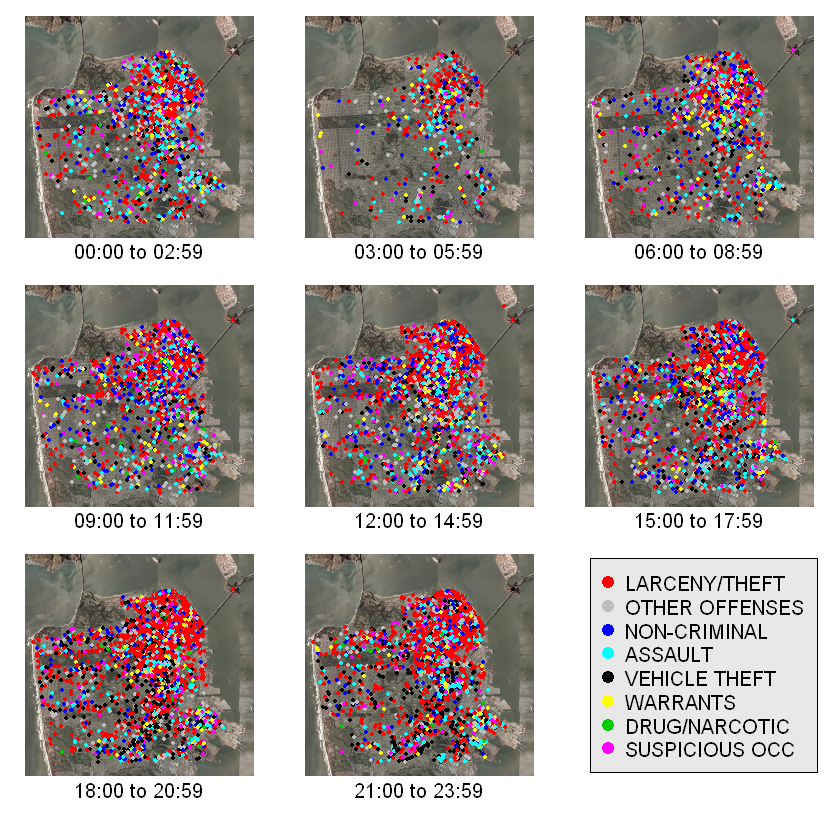

In [22]:
par(oma=c(2,0,0,0), mar=c(2,1,1,1), mfrow=c(3,3))
for(j in 0:7)
{
plot(sfMap, removeMargin = FALSE)
sfCrimeOSMtop8Time=sfCrimeOSMtop8[sfCrimeOSMtop8$hour==j,]
plot(sfCrimeOSMtop8Time,add=TRUE,col=sfCrimeOSMtop8Time$color
     , pch=20, cex=1)
mtext(paste(timePeriods[j+1]), side = 1, line = 0.5, outer = FALSE)
}
par(xpd=NA)
legend('right', inset=c(-1.1,0), legend=jColors$cat,
       col=jColors$color,pch=20, cex=1.5, bg=alpha('lightgray',0.5),
       , pt.cex=3)
#mtext('Eight Most Common Crimes by Time and Location', side = 1, line = 2.5, outer = FALSE,
#      cex=1.5)

From the maps we see that Larceny/Theft is the most common crime cetegory and these crimes seem to be concentrated in the North-East of the city. They also occur more frequently in the evening, particularly between 6pm and 9pm.

Non-criminal offences appear to be the most prevalent during the morning and afternoon but are less common in the evening. They also tend to more evenly distributed throughout the city.